# Demo: WFIRST CGI simulation with WebbPSF

This tutorial will walk you through the basics of using the WebbPSF package to calculate PSFs for WFIRST CGI.

First, we set up the notebook to display plots inline, and to plot images with the origin in the lower left.

In [8]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'

Populating the interactive namespace from numpy and matplotlib


## Getting Started

In [9]:
import os
os.environ['WEBBPSF_PATH'] = '../webbpsf-data'
import webbpsf
from webbpsf import wfirst

WebbPSF produces various log messages while it works, using Python's built-in logging mechanism. In order to see them, we need to set up a log handler that will display them on the screen. This is done using the ``setup_logging`` function. 

In [10]:
webbpsf.setup_logging()

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.


We can also choose to save log outputs to a file, if that's desired.

In [11]:
webbpsf.setup_logging(filename='my_log.txt')

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.
WebbPSF log outputs will also be saved to file my_log.txt


## Characterization mode SPC

Now let's get started with some calculations. To calculate a PSF, we first instantiate an instrument object: 

In [12]:
cg = wfirst.CGI()

Now we set the coronagraph observing mode and filter. There are two modes implemented so far, both shaped pupil designs: 'CHARSPC' and 'DISKSPC' -- these are the characterization and debris disk imaging modes of CGI, respectively. The filters choices for 'CHARSPC' are 'F660','F770', and 'F890' (18% bandwidth IFS filters centered at 660 nm, 770 nm, and 890 nm). Filter choices for 'DISKSPC' are 'F465', 'F565', 'F835', and 'F865', all 10% bandwidth imaging filters. 

In [13]:
cg.mode = 'CHARSPC'
cg.filter = 'F770'

And then call its ``calcPSF`` function.  Note the log output describes various details of the calculation as it proceeds. The returned result is a fits HDUList object containing both the image data and its associated metadata in the header. 

INFO:webbpsf:Setting up PSF calculation for CGI
INFO:poppy:Computing wavelength weights using synthetic photometry for F770...
INFO:webbpsf:PSF calc using fov_pixels = 160, oversample = 2, number of wavelengths = 1
INFO:webbpsf:Creating optical system model:
INFO:poppy:Initialized OpticalSystem: WFIRST+CGI
INFO:poppy:WFIRST Pupil: Loaded amplitude transmission from ../webbpsf-data/AFTA_CGI_C5_Pupil_onax_1000px.fits
INFO:poppy:Added pupil plane: WFIRST Pupil
INFO:poppy:CHARSPC: Loaded amplitude transmission from ../webbpsf-data/CGI/optics/CHARSPC_SP_1000pix.fits.gz
INFO:poppy:Added pupil plane: CHARSPC
INFO:poppy:Optic from ../webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res8_evensamp_D144_F770.fits.gz: Loaded amplitude transmission from ../webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res8_evensamp_D144_F770.fits.gz
INFO:poppy:Added image plane: Optic from ../webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res8_evensamp_D144_F770.fits.gz
INFO:poppy:SPC26D88

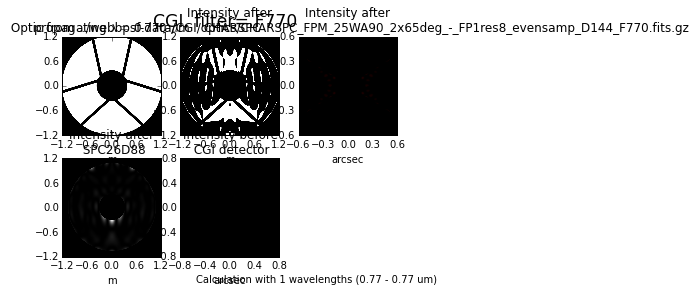

In [14]:
monopsf = cg.calcPSF(nlambda=1, fov_pixels=160, oversample=2, display=True)

As you can see, the log output can be fairly verbose. This is often helpful in terms of understanding what's going on, but for purposes of this documentation it will make for easier reading to turn off display of informational messages:

In [15]:
webbpsf.setup_logging('ERROR')

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


We can display the PSF that we have just created:

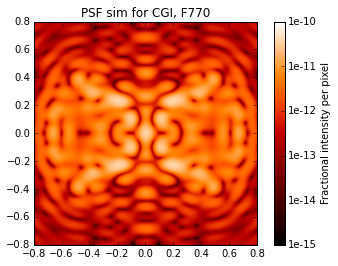

In [16]:
webbpsf.display_PSF(monopsf,ext=1,vmin=1e-15, vmax=1e-10)

## Debris disk mode SPC

In [17]:
diskcg = wfirst.CGI()
diskcg.mode = 'DISKSPC'
diskcg.filter = 'F565'

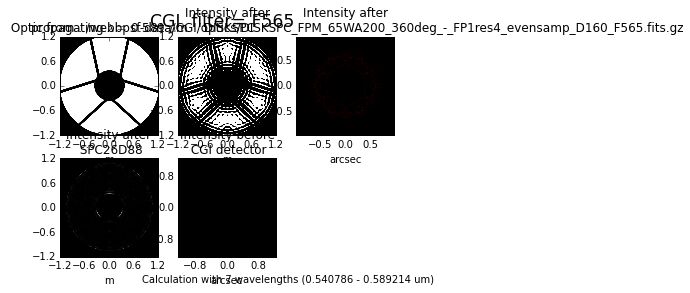

In [18]:
diskpsf = diskcg.calcPSF(nlambda=7, fov_pixels=250, oversample=2, display=True)

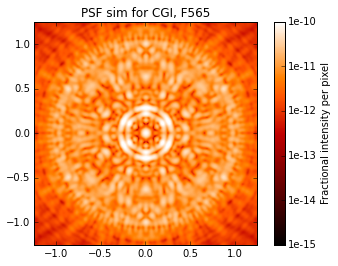

In [19]:
webbpsf.display_PSF(diskpsf,ext=1,vmin=1e-15, vmax=1e-10)

### Off-axis PSF

In [20]:
diskcg.options['source_offset_r'] = 0.5 # arcsec
diskcg.options['source_offset_theta'] = -90. # deg w.r.t. North

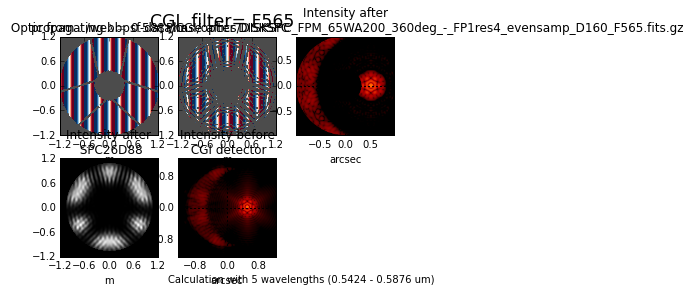

In [21]:
offax_diskpsf = diskcg.calcPSF(nlambda=5, fov_pixels=250, oversample=2, display=True)

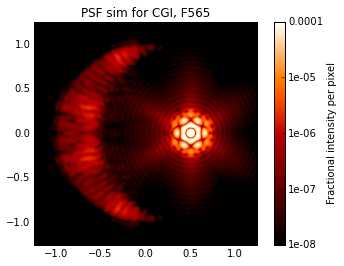

In [22]:
webbpsf.display_PSF(offax_diskpsf,vmax=1e-4)

In [23]:
# comb_img = diskpsf[1].data + offax_diskpsf[1].data*1e-10
comb_img = diskpsf[1].data

In [24]:
import astropy.io.fits as fits
comb_hdu = fits.PrimaryHDU(comb_img, header=diskpsf[1].header)
comb_hdulist = fits.HDUList([comb_hdu])

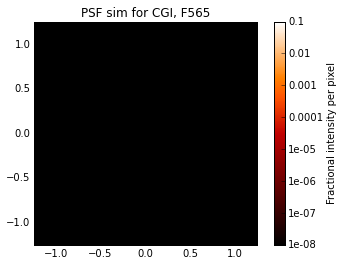

In [25]:
webbpsf.display_PSF(comb_hdulist)